In [87]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from common import CosmoInterpolator
import json
import healpy as hp

label_fontsize = 18
tick_fontsize = 18
title_fontsize = 18

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.figsize"] = (4, 3)


In [88]:
cosmo = CosmoInterpolator()
h5_path = "pe_results.h5"
h5f = h5py.File(h5_path, "r")
snr_threshold = 10.0

In [89]:
processed_results = []
for source in h5f:
    # if "a=-0.99" in source:
    # Extract m1 and redshift using regex
    m1_match = re.search(r"m1=([0-9.eE+-]+)", source)
    z_match = re.search(r"z=([0-9.eE+-]+)", source)
    a_match = re.search(r"a=([0-9.eE+-]+)", source)
    if m1_match and z_match:
        m1 = float(m1_match.group(1))
        z = float(z_match.group(1))
        a = float(a_match.group(1))
        snr = h5f[source]["snr"][()]
        sky_loc = h5f[source]["sky_loc"][()]
        # print(h5f[source]["absolute_errors_a"]["error_detector"][...])
        # for key in h5f[source].keys():
        #     print(key)
        #     print(f"{key}: {h5f[source][key]['error_detector'][()].shape}")
        snr_cut = snr > snr_threshold
        sky_loc = sky_loc[snr_cut]
        temp_ = {key: h5f[source][key]["error_source"][snr_cut] for key in h5f[source].keys() if "error" in key}
        processed_results.append({'m1': m1, 'a': a, 'redshift': z, 'snr': snr[snr_cut], 'sky_loc': sky_loc, **temp_})

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(processed_results)
np.sum(df_results['a'] == 0.99),np.sum(df_results['a'] == -0.99),np.sum(df_results['a'] == 0.0),
print(df_results.columns.tolist())


['m1', 'a', 'redshift', 'snr', 'sky_loc', 'absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0', 'relative_errors_M', 'relative_errors_mu']


In [90]:
m1_list = np.unique(df_results["m1"].to_numpy())

def get_error(error_name='relative_errors_M', a=0.99):
    df_temp = df_results[(df_results['a'] == a)]
    snr = df_temp["snr"][(df_results['a'] == a)].to_numpy()    
    err = df_temp[error_name].to_numpy()
    mlist = df_results["m1"][(df_results['a'] == a)].to_numpy()
    skyloc = df_temp["sky_loc"][(df_results['a'] == a)].to_numpy()
    return mlist, err, snr, skyloc

mvec, errors, snr_values, skyloc_values =  get_error()

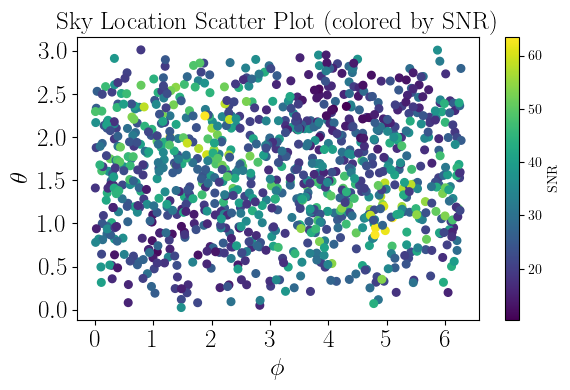

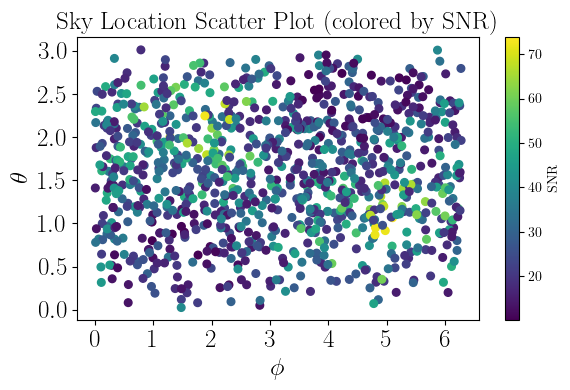

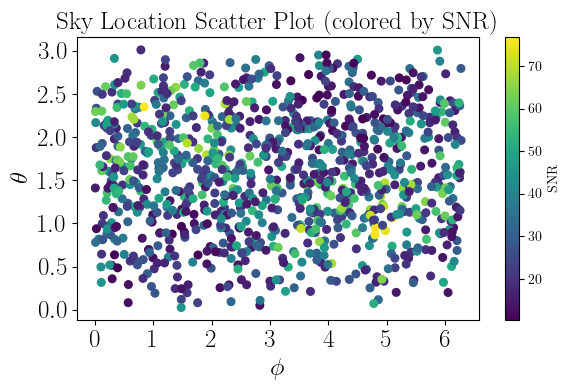

In [91]:
ind = 0
for ind in range(len(mvec)):

    sky_loc = skyloc_values[ind]
    theta = sky_loc[:, 0]
    phi = sky_loc[:, 1]
    plt.figure(figsize=(6, 4))
    sc = plt.scatter(phi, theta, c=snr_values[ind], cmap='viridis', s=30)
    plt.colorbar(sc, label='SNR')
    plt.xlabel(r'$\phi$', fontsize=label_fontsize)
    plt.ylabel(r'$\theta$', fontsize=label_fontsize)
    plt.title('Sky Location Scatter Plot (colored by SNR)', fontsize=title_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.tight_layout()
    plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2140494/886578985.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(f"$\log_{{10}}$ {ylabel}", fontsize=label_fontsize)


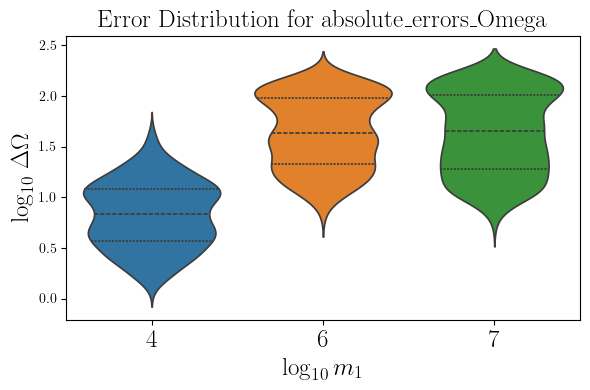

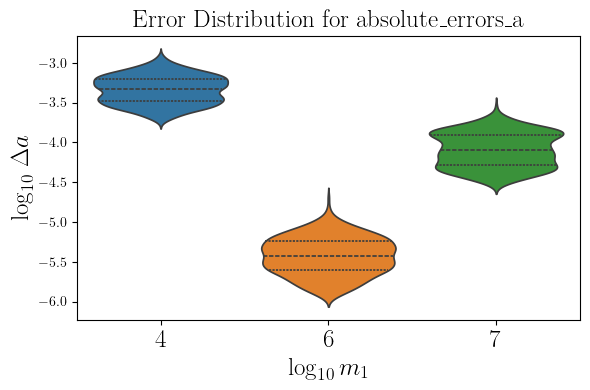

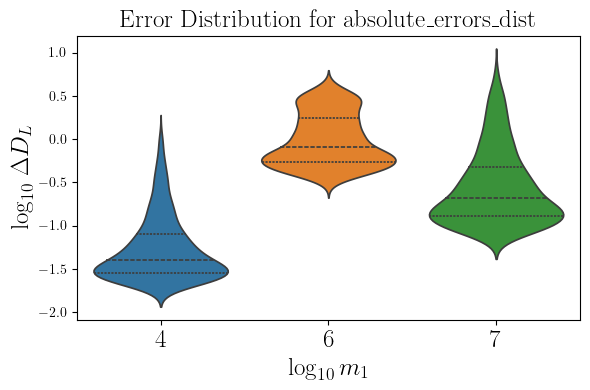

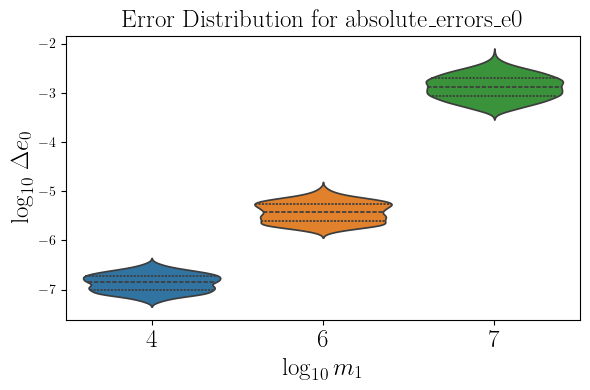

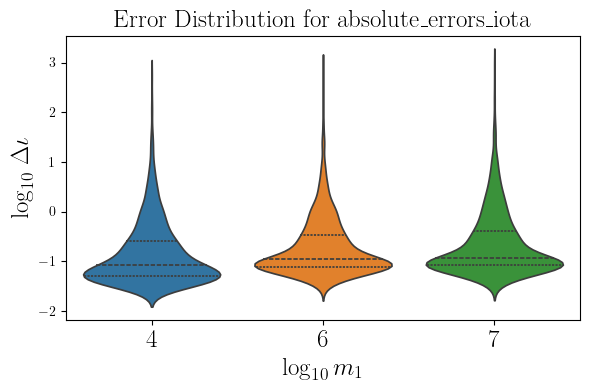

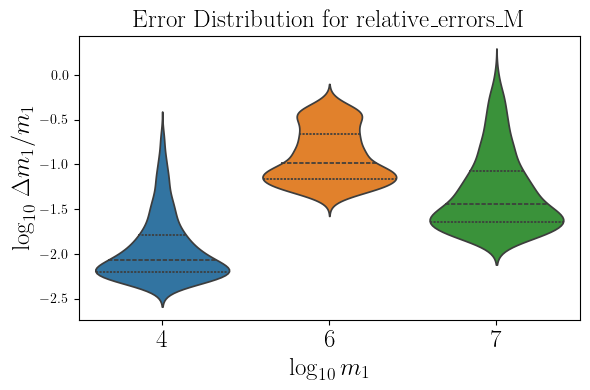

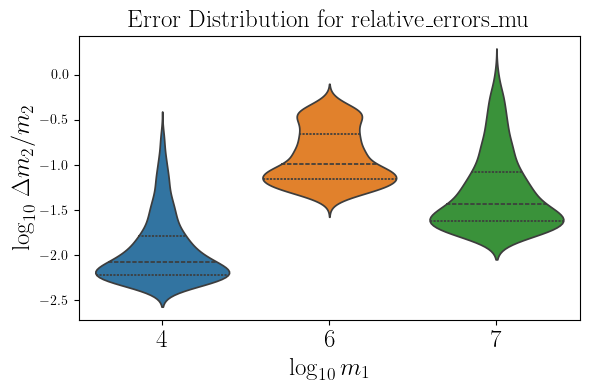

In [96]:
from matplotlib.ticker import ScalarFormatter

list_error_names =  ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'relative_errors_M', 'relative_errors_mu']
ylabels = [r"$\Delta \Omega$", r"$\Delta a$", r"$\Delta D_L$", r"$\Delta e_0$", r"$\Delta \iota$", r"$\Delta m_1/m_1$", r"$\Delta m_2/m_2$"]
for ername, ylabel in zip(list_error_names, ylabels):
    mvec, errors, snr_values, sky = get_error(error_name=ername)
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=[np.log10(errors[0]), np.log10(errors[1]), np.log10(errors[2])], inner="quartile")
    plt.xticks(ticks=np.arange(len(mvec)), labels=[f"{int(np.log10(m))}" for m in mvec], fontsize=tick_fontsize)
    plt.xlabel(r"$\log_{{10}}m_1$", fontsize=label_fontsize)
    plt.ylabel(f"$\log_{{10}}$ {ylabel}", fontsize=label_fontsize)
    plt.title(f"Error Distribution for {ername}", fontsize=title_fontsize)
    # plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    plt.tight_layout()
    plt.show()


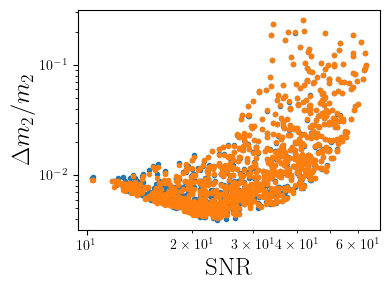

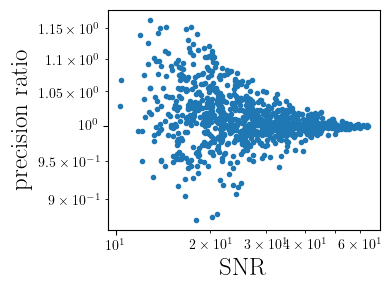

In [65]:
list_error_names =  ['absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist', 'absolute_errors_e0', 'absolute_errors_iota', 'relative_errors_M', 'relative_errors_mu']
ylabels = [r"$\Delta \Omega$", r"$\Delta a$", r"$\Delta D_L$", r"$\Delta e_0$", r"$\Delta \iota$", r"$\Delta m_1/m_1$", r"$\Delta m_2/m_2$"]
mvec, errors, snr_values, sky = get_error(error_name=ername)

ind = 0

plt.figure()
ername, ylabel = list_error_names[5], ylabels[5]
mvec, errors_1, snr_values, sky = get_error(error_name=ername)
plt.loglog(snr_values[ind], errors_1[ind], '.')

ername, ylabel = list_error_names[6], ylabels[6]
mvec, errors_2, snr_values, sky = get_error(error_name=ername)
plt.loglog(snr_values[ind], errors_2[ind], '.')
plt.xlabel(r"SNR", fontsize=label_fontsize)
plt.ylabel(f"{ylabel}", fontsize=label_fontsize)
# plt.title(f"Error Distribution for {ername}", fontsize=title_fontsize)
plt.tight_layout()
plt.show()

plt.figure()
plt.loglog(snr_values[ind], errors_1[ind]/errors_2[ind], '.')
plt.xlabel(r"SNR", fontsize=label_fontsize)
plt.ylabel(f"precision ratio", fontsize=label_fontsize)
# plt.title(f"Error Distribution for {ername}", fontsize=title_fontsize)
plt.tight_layout()
plt.show()

# for ername, ylabel in zip(list_error_names, ylabels):
#     mvec, errors, snr_values, sky = get_error(error_name=ername)
#     plt.figure()
#     plt.loglog(snr_values[1], errors[1], '.')
#     plt.xlabel(r"SNR", fontsize=label_fontsize)
#     plt.ylabel(f"{ylabel}", fontsize=label_fontsize)
#     # plt.title(f"Error Distribution for {ername}", fontsize=title_fontsize)
#     plt.tight_layout()
#     plt.show()


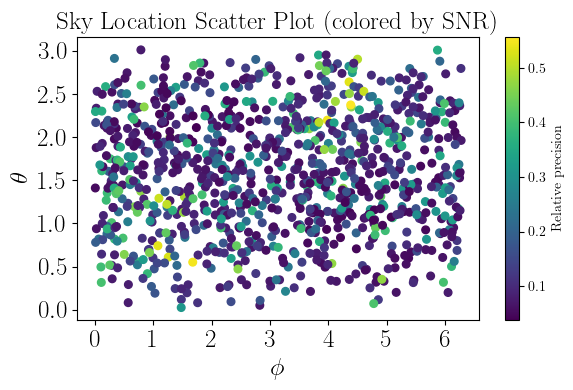

In [70]:
ind = 1
ername, ylabel = list_error_names[5], ylabels[5]
mvec, errors, snr_values, sky = get_error(error_name=ername)

sky_loc = sky[ind]
theta = sky_loc[:, 0]
phi = sky_loc[:, 1]
plt.figure(figsize=(6, 4))
sc = plt.scatter(phi, theta, c=errors[ind], cmap='viridis', s=30)
plt.colorbar(sc, label='Relative precision')
plt.xlabel(r'$\phi$', fontsize=label_fontsize)
plt.ylabel(r'$\theta$', fontsize=label_fontsize)
plt.title('Sky Location Scatter Plot (colored by SNR)', fontsize=title_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.tight_layout()
plt.show()